In [1]:
import torchio as tio
import os
import radiomics
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from skimage import measure
import torch
import scipy

from ipywidgets import widgets, interact
import matplotlib.pyplot as plt

In [ ]:
# import logging
# logger = logging.getLogger("radiomics")
# logger.setLevel(logging.ERROR) #To ignore warnings

# Data IO

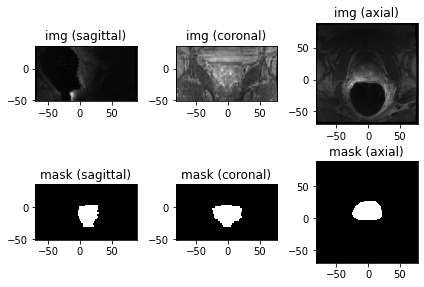

In [2]:
img_path = r"./data/PCAMPMRI-00001/image.nii.gz"
mask_path = r"./data/PCAMPMRI-00001/mask.nii.gz"
sub = tio.Subject(img=tio.Image(img_path),mask=tio.LabelMap(mask_path))
sub.plot()#Fast Visualization

In [3]:
#Interactive Visualization

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

img_arr = sitk.GetArrayFromImage(sitk_img)#Z,X,Y
mask_arr = sitk.GetArrayFromImage(sitk_mask)

spacing_W, spacing_H, _ = sitk_img.GetSpacing()

def visualize(i):
    
    plt.imshow(img_arr[i],cmap='gray')
    if mask_arr[i].sum()>0:
        plt.contour(mask_arr[i])
    plt.show()
    
interact(visualize, i=widgets.IntSlider(len(mask_arr)//2,0,len(mask_arr),1))

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

<function __main__.visualize(i)>

# Contour Augmentation

In [5]:
class ContourInPlaneAug(object):
    
    def __init__(self, w_spacing, h_spacing, w_stdMM,h_stdMM, angle, ob_type="random"): 
        '''
        w_spacing, h_spacing represents the spacing of the input image
        
        w_aMM, w_bMM are the measurements in MM; acts as the bound for variability along the in-plane directions
        
        angle - rotate Z such that ~ U(-angle,angle)
        
        ob_type specifies the bias types; can be either 'random' or 'systematic'
        '''
        
        
        self.w_spacing = w_spacing
        self.h_spacing = h_spacing
        
        self.w_stdMM = w_stdMM
        self.h_stdMM = h_stdMM
        self.angle = angle
        
        self.ob_type = ob_type
    
    def __call__(self, mask):  
        
        sys_type = np.random.choice(["inc","dec"]) #will only be considered if the bias type is systematic; 

        out_mask = torch.zeros_like(mask)
        
        z_indeces = [i.item() for i in torch.where(mask)[1].unique()] #To identify the slices where the ROI is present
        
        for z in z_indeces:
            
            if self.ob_type=="random":
                w_stdVOX = np.ceil(np.random.uniform(-self.w_stdMM,self.w_stdMM)/self.w_spacing) #conversion to equivalent voxels
                h_stdVOX = np.ceil(np.random.uniform(-self.h_stdMM,self.h_stdMM)/self.h_spacing)
                
            elif self.ob_type=="systematic":
                
                if sys_type == "inc":
                    w_stdVOX = np.ceil(np.random.uniform(0,self.w_stdMM)/self.w_spacing)
                    h_stdVOX = np.ceil(np.random.uniform(0,self.h_stdMM)/self.h_spacing)
                else:
                    w_stdVOX = np.ceil(np.random.uniform(-self.w_stdMM,0)/self.w_spacing)
                    h_stdVOX = np.ceil(np.random.uniform(-self.h_stdMM,0)/self.h_spacing)
            
            props = measure.regionprops(mask[0,z].data.numpy())
            w_min,h_min,w_max,h_max = props[0].bbox

            dw = w_max - w_min
            dh = h_max - h_min

            aug_dw = dw + w_stdVOX 
            aug_dh = dh + h_stdVOX 

            factor_w  = np.round(aug_dw/dw,2)
            factor_h = np.round(aug_dh/dh,2)
            
            if factor_w<=0:
                continue;
            
            if factor_h<=0:
                continue;
            
            scales = (1,1,factor_w,factor_w,factor_h,factor_h)#Z,Z,X,X,Y,Y
        
            degrees = (-self.angle, self.angle, 0, 0, 0, 0)#Z,X,X,Y,Y

            transform = tio.RandomAffine(scales=scales,degrees=degrees,p=1)

            out_mask[0,z] = transform(mask[0,z].unsqueeze(0).unsqueeze(0))[0,0]
            
           
        
        out_mask[out_mask>0.5] = 1
        out_mask[out_mask<=0.5] = 0
        
        
        return out_mask
        
        

In [6]:
class ContourOutPlaneAug(object):
    
    def __init__(self, scale_a, scale_b,angle, delta_z):
        
        '''
        scale_a, scale_b and angle are transformation params and is only used when we synthesize masks beyond the GT boundaries
        
        delta_z is the maximum shift or out-plane augmentation allowed
        '''
        
        self.scale_a = scale_a
        self.scale_b = scale_b
        self.angle = angle
        
        self.delta_z = delta_z
        
    def __call__(self, mask):
        
        mask = mask.clone()
    
        aug_num_slices = np.random.randint(0, self.delta_z+1) #low, high (excluded high)
        
        z_indeces = [i.item() for i in torch.where(mask)[1].unique()]
        
        z_min, z_max = min(z_indeces), max(z_indeces)
        
        for i in range(aug_num_slices):
        
            dz = z_max-z_min

            if dz>0: 

                ref_z = np.random.choice([z_min,z_max])
                
                flag = -1 if ref_z==z_min else 1

                aug_type = "del" if np.random.uniform()>0.5 else "add"
            
                if mask[0,ref_z].sum()>0: #which means contour exists in that place, possible that it got deleted during iteration
                
                    if aug_type=="del":
                        if ref_z+flag in range(mask.shape[1]):
                            if mask[0,ref_z+flag].sum()==0:#to check if new contours were inserted up or down
                                mask[0,ref_z] = torch.zeros(*mask[0,ref_z].shape)
                                
                        else:#if ref_z+flag is outside the boundary
                            mask[0, ref_z] = torch.zeros(*mask[0,ref_z].shape)

                    elif aug_type=="add":

                        if ref_z+flag in range(mask.shape[1]):
                            
                            if mask[0,ref_z+flag].sum()==0:

                                scales =(1,1,self.scale_a,self.scale_b,self.scale_a,self.scale_b)
                                degrees = (-self.angle, self.angle,0,0,0,0)

                                transform = tio.RandomAffine(scales=scales,degrees=degrees,p=1)

                                mask[0,ref_z+flag] = transform(mask[0,ref_z].unsqueeze(0).unsqueeze(0))[0,0]

        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        
        return mask
   


In [24]:
def vol_dice_score(y_pred,y_true, smooth=1e-4):

    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    wp = 1

    tp = wp * ((y_pred * y_true).sum())
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()

    return (2 * tp +smooth) / (2 * tp + fp + fn + smooth)

# Main Body

In [14]:
IN_AUG_PARAMS = {'w_spacing':None,"h_spacing":None,'w_stdMM':2.7,'h_stdMM':2.7, 'angle':5,'ob_type':None}
OUT_AUG_PARAMS = {'scale_a':0.6,'scale_b':0.8,'angle':5,'delta_z':2}
AUGMENT_COUNT = 15

aug_type = "inout_plane"
bias_type = "random"

In [27]:
assert aug_type in ["in_plane","out_plane","inout_plane"], "Invalid aug_type!"
assert bias_type in ["random","systematic"], "Invalid bias_type!"

if aug_type=="in_plane":
                    
        IN_AUG_PARAMS["w_spacing"] = spacing_W
        IN_AUG_PARAMS["h_spacing"] = spacing_H
        IN_AUG_PARAMS["ob_type"] = bias_type

        ContourAug = tio.Lambda(ContourInPlaneAug(**IN_AUG_PARAMS),types_to_apply=[tio.LABEL])

elif aug_type=="out_plane":

    ContourAug = tio.Lambda(ContourOutPlaneAug(**OUT_AUG_PARAMS), types_to_apply=[tio.LABEL])

elif aug_type=="inout_plane":

    IN_AUG_PARAMS["w_spacing"] = spacing_W
    IN_AUG_PARAMS["h_spacing"] = spacing_H
    IN_AUG_PARAMS["ob_type"] = bias_type

    ContourAug = tio.Compose([
        tio.Lambda(ContourInPlaneAug(**IN_AUG_PARAMS),types_to_apply=[tio.LABEL]),
        tio.Lambda(ContourOutPlaneAug(**OUT_AUG_PARAMS), types_to_apply=[tio.LABEL])
    ])


pbar = tqdm(range(AUGMENT_COUNT),desc=f"Generating {aug_type} augmentation with {bias_type} bias", position=0)
sub = tio.Subject(mask=tio.LabelMap(tensor=mask_arr[np.newaxis,...]))

for i in range(AUGMENT_COUNT):
    
    aug_sub = ContourAug(sub)
    aug_mask_arr = aug_sub["mask"]["data"][0].numpy()
    
    k = len(img_arr)//2 #middle slice
    dice = vol_dice_score(aug_mask_arr[k], mask_arr[k])
    
    plt.imshow(img_arr[k],cmap='gray')
    plt.contour(aug_mask_arr[k], colors='red')#Synthetic ROI
    plt.contour(mask_arr[k], colors='green')#GT ROI
    plt.title(f"Contour #{i+1} (DI:{dice:0.2f})")
    plt.show()
    
    pbar.update()
    
#     #To export the augmented mask
#     aug_sitk_mask = sitk.GetImageFromArray(aug_mask_arr)
#     aug_sitk_mask.SetOrigin(sitk_img.GetOrigin())
#     aug_sitk_mask.SetSpacing(sitk_img.GetSpacing())
#     sitk.WriteImage(aug_sitk_mask,"./data/aug_sitk_mask.nii.gz")
    



Generating inout_plane augmentation with random bias: 100%|████████████████████████████| 15/15 [00:10<00:00,  1.51it/s]

# Interactive Visualization GT and Synthetic ROI Example

In [28]:
def visualize(i):
    
    plt.imshow(img_arr[i],cmap='gray')
    if mask_arr[i].sum()>0:
        plt.contour(mask_arr[i],colors='green')
    if aug_mask_arr[i].sum()>0:
        plt.contour(aug_mask_arr[i],colors='red')
    
    plt.title(f"Slice:{i}, DI:{vol_dice_score(aug_mask_arr[i],mask_arr[i]):0.2f}")
    plt.show()
    
interact(visualize, i=widgets.IntSlider(len(mask_arr)//2,0,len(mask_arr),1))

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

<function __main__.visualize(i)>